<a href="https://colab.research.google.com/github/NV2019/AERO_625_Platooning/blob/main/MC_Dissimilar_Neighborhood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages('patchwork')
install.packages('cowplot')
install.packages('wesanderson')

library(ggplot2)
library(patchwork) 
library(cowplot)
library(tidyverse)
library(wesanderson)
library(tidyverse)

csv = 'data.csv'

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.4.1
✔ readr   2.1.4     ✔ forcats 1.0.0
✔ purrr   1.0.1     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
rm(list = ls())

# Asymmetry parameter
alpha_values <- 0:20

# Total Simulation Time
FinalTime <- 300

Final_Mean_Time <- matrix(0,nrow=length(alpha_values))

Final_Sd_Time <- matrix(0,nrow=length(alpha_values))

Final_Mean_IPA <- matrix(0,nrow=length(alpha_values),ncol=FinalTime)

Final_Mean_OPA <-  matrix(0,nrow=length(alpha_values),ncol=FinalTime)

Final_Mean_Affect <-  matrix(0,nrow=length(alpha_values),ncol=FinalTime)

Final_Sd_IPA <- matrix(0,nrow=length(alpha_values),ncol=FinalTime)

Final_Sd_OPA <-  matrix(0,nrow=length(alpha_values),ncol=FinalTime)

Final_Sd_Affect <-  matrix(0,nrow=length(alpha_values),ncol=FinalTime)

MonteCarlo <- 100

MC_IPA <- matrix(0,nrow=MonteCarlo,ncol=FinalTime)

MC_OPA <-  matrix(0,nrow=MonteCarlo,ncol=FinalTime)

MC_Affect <-  matrix(0,nrow=MonteCarlo,ncol=FinalTime)

mapply(function(x){

  mapply(function(y){
    # -----------------------------------------------------------------------------------------------------------------------
    # Parameter Initialization
    # ----------------------------
      
    # Population Parameters

    # Group Size
    TotalPopulation <- 1000
    # Probability of an agent being left wing
    LeftWing <- 0.5
    # Probability of an agent being right wing
    RightWing <- 1.0-LeftWing
    # Probability of an agent being exposed to news from sources
    ExposureRate <- 0.01
    # Probability of an agent being exposed to retweets
    RetweetsExposure <- 0.5
    # Probability that an agent will retweet
    RetweetRate <- 1
    # All Possible slants
    Slants <- c(1,2)

    # Simulation Parameters
    # Asymmetry parameter
    alpha <- x

    # Network Parameters

    # Minimum degree of each node
    MinimumDegree <- 0.01*TotalPopulation
    # Maximum degree of each node
    MaximumDegree <- 0.1*TotalPopulation
    # Indices of nodes
    Nodes <- 1:TotalPopulation
    # Degree of each node
    NodeDegree <- sample(MinimumDegree:MaximumDegree,TotalPopulation,replace=TRUE,p=NULL)
    # Extent of similarity of slant in individual neighborhood
    NeighborhoodSimilarity <- 0

    # -----------------------------------------------------------------------------------------------------------------------
    # Placeholder Initialization
    # ----------------------------

    # Time Series Values: 1=MeanIPA, 2=MeanOPA, 3=MeanAffect
    MeanTimeSeriesValues <- matrix(0,nrow=5,ncol=FinalTime)
    # Matrix to store indices of neighbors
    NeighborsMatrix <- matrix(0,nrow = TotalPopulation,ncol=MaximumDegree)
    # Agent Attributes: 1=Slant, 2=IPA, 3=OPA, 4=NewsTargets, 5=SlantofNewsExposure, 
    # 6=ExposedStatus, 7=DifferenceinSlants, 8=Gain
    Agents <- matrix(0,nrow=TotalPopulation,ncol=10)
    Vectors <- matrix(0,nrow=TotalPopulation,ncol=10)
    # Slant
    Agents[,1] <- sample(1:2, TotalPopulation, replace = TRUE, prob = c(LeftWing,RightWing))
    # IPA
    Agents[,2] <- sample(50:70, TotalPopulation, replace = TRUE, prob = NULL)
    #OPA
    Agents[,3] <- sample(30:50, TotalPopulation, replace = TRUE, prob = NULL)

    # -----------------------------------------------------------------------------------------------------------------------
    # Constructing the similarity/dissimilarity network
    # --------------------------------------------------

    # Identifying slant of neighbors based on neighborhood_similarity parameter
    NeighborhoodSlant <- mapply(function(x){
      sample(c(Agents[x,1],Slants[Slants!=Agents[x,1]]),NodeDegree[x],replace=TRUE,p=c(NeighborhoodSimilarity,1-NeighborhoodSimilarity))},Nodes)
    mapply(function(x){
    # Identify the indices with slant 1
    if (length(which(NeighborhoodSlant[[x]]==1))!=0 & length(which(NeighborhoodSlant[[x]]==1))<NodeDegree[x]){
      NeighborsMatrix[x,1:length(which(NeighborhoodSlant[[x]]==1))] <<- sample(which(Agents[,1]==1)[which(Agents[,1]==1)!=x])[1:length(which(NeighborhoodSlant[[x]]==1))]
      # Identify the indices with slant 2
      NeighborsMatrix[x,(length(which(NeighborhoodSlant[[x]]==1))+1):NodeDegree[x]] <<- sample(which(Agents[,1]==2)[which(Agents[,1]==2)!=x])[1:length(which(NeighborhoodSlant[[x]]==2))]}
    else {
      if (length(which(NeighborhoodSlant[[x]]==1))==NodeDegree[x]){
        NeighborsMatrix[x,1:length(which(NeighborhoodSlant[[x]]==1))] <<- sample(which(Agents[,1]==1)[which(Agents[,1]==1)!=x])[1:length(which(NeighborhoodSlant[[x]]==1))]}
      else{
        NeighborsMatrix[x,1:length(which(NeighborhoodSlant[[x]]==2))] <<- sample(which(Agents[,1]==2)[which(Agents[,1]==2)!=x])[1:length(which(NeighborhoodSlant[[x]]==2))]}
    }},Nodes)

    for (t in 1:FinalTime){
      # print("Iteration,", t)
      # Mean IPA
      MeanTimeSeriesValues[1,t] <- mean(Agents[,2])
      # Mean OPA
      MeanTimeSeriesValues[2,t] <- mean(Agents[,3])
      # Affect
      MeanTimeSeriesValues[3,t] <- MeanTimeSeriesValues[1,t] - MeanTimeSeriesValues[2,t]

      # News Content
      Agents[,5] <- sample(1:2,TotalPopulation,replace=TRUE,prob=NULL)
      # News_Exposed
      Agents[,6] <- 0
      Agents[,6] <- (runif(TotalPopulation)<ExposureRate)
      # Not exposed to news, news content is 0
      Agents[Agents[,6]==0,5] <- 0
      # Retweeting Status 
      Vectors[,3] <- Agents[,7]
      # Retweet Exposure
      Vectors[,5] <- Agents[,8]
      # Reset exposure to retweets
      Agents[,8] <- 0

      # Difference
      # Update of those exposed to retweets/news previously
      Agents[,9] <- abs(Agents[,1] - Vectors[,4])
      # Gain
      Agents[,10] <- -alpha-10*(exp(2*(Agents[,9]-0.5))-1)/(exp(2*(Agents[,9]-0.5))+1)
      Agents[(Vectors[,5]==0)&(Vectors[,2]==0),10] <- 0
      # cat("Updating,", which(!((Vectors[,5]==0)&(Vectors[,2]==0))),"\n",sep="\t")
      #New IPA
      Agents[Agents[,10]>0,2] <- Agents[Agents[,10]>0,2] + Agents[Agents[,10]>0,10] 
      Agents[Agents[,2]>100,2] <- 100
      #New OPA
      Agents[Agents[,10]<0,3] <- Agents[Agents[,10]<0,3] + Agents[Agents[,10]<0,10]  
      Agents[Agents[,3]<0,3] <- 0

      # Retweet exposure
      temporary_neighbors_list <- mapply(function(x){
        # Store neighbors list for manipulation
        temporary_neighbors_list <- NeighborsMatrix
        # Rid neighbors exposed to news
        temporary_neighbors_list[x,which(Agents[temporary_neighbors_list[x,],6]==1)] <- 0
        # Rid neighbors exposed to retweaets
        temporary_neighbors_list[x,which(Vectors[temporary_neighbors_list[x,],5]==1)] <- 0    
        # Retweet Exposed
        Agents[temporary_neighbors_list[x,],8] <<- sample(0:1,length(which(temporary_neighbors_list[x,]!=0)),replace=TRUE,p=c(1-RetweetsExposure,RetweetsExposure))
        # Retweet Slant
        Agents[temporary_neighbors_list[x,which(Agents[temporary_neighbors_list[x,],8]==1)],4] <<- Vectors[x,4]
      },which(Vectors[,3]==1))

      # News Content
      Vectors[,1] <- Agents[,5]
      # Exposure
      Vectors[,2] <- Agents[,6]
      # cat("news exposure,", which(Vectors[,2]==1),"\n",sep="\t")
      # Retweeting Status
      Agents[,7] <- 0
      # Retweeting Content
      Agents[Agents[,8]==1,5] <- Agents[Agents[,8]==1,4]
      # cat("retweet exposure,", which(Agents[,8]==1),"\n",sep="\t")
      # Exposed to News/Retweets and Retweeting
      Agents[,7] <- ((runif(TotalPopulation)<RetweetRate) & (Agents[,1]==Agents[,5]) & ((Agents[,6]==1)|(Agents[,8]==1))) 
      # News and Retweeting Content
      Vectors[,4] <- Agents[,5]
      # cat("news or retweet exposure,", which(Agents[,7]==1),"\n",sep="\t")

    }

    MC_IPA[y,] <<- MeanTimeSeriesValues[1,]

    MC_OPA[y,] <<- MeanTimeSeriesValues[2,]

    MC_Affect[y,] <<- MeanTimeSeriesValues[3,]  

  },1:MonteCarlo)

Final_Mean_Time[x+1,] <<- mean(mapply(function(z){which(MC_OPA[z,]==0)[1]},1:MonteCarlo))

Final_Sd_Time[x+1,] <<- sd(mapply(function(z){which(MC_OPA[z,]==0)[1]},1:MonteCarlo))

Final_Mean_IPA[x+1,] <<- apply(MC_IPA,2,mean)

Final_Mean_OPA[x+1,] <<- apply(MC_OPA,2,mean)

Final_Mean_Affect[x+1,] <<- apply(MC_Affect,2,mean)

Final_Sd_IPA[x+1,] <<- apply(MC_IPA,2,sd)

Final_Sd_OPA[x+1,] <<- apply(MC_OPA,2,sd)

Final_Sd_Affect[x+1,] <<- apply(MC_Affect,2,sd)

},alpha_values)


0.2657346,0.2204510,0.2822553,0.2509526,0.2439528,0.2639729,0.2742142,0.2756813,0.2818704,0.2495985,⋯,0.2858067,0.2846362,0.2462985,0.2630131,0.2858351,0.2648174,0.2575976,0.2331665,0.2976106,0.2500606
0.2657346,0.2204510,0.2822553,0.2509526,0.2439528,0.2639729,0.2742142,0.2756813,0.2818704,0.2495985,⋯,0.2858067,0.2846362,0.2462985,0.2630131,0.2858351,0.2648174,0.2575976,0.2331665,0.2976106,0.2500606
0.2668355,0.2217390,0.2803371,0.2529017,0.2450367,0.2657019,0.2726252,0.2775887,0.2849661,0.2485160,⋯,0.2880677,0.2795727,0.2505567,0.2660706,0.2875239,0.2658570,0.2604473,0.2483846,0.2985978,0.2546363
0.3562219,0.3975052,0.4342116,0.5164873,0.4835100,0.5875088,0.6857952,0.7317351,0.6589534,0.8091163,⋯,0.9528820,0.9797127,1.0827053,1.0986822,1.0266885,0.9597267,1.3142999,1.3756028,1.2144365,1.4949114
0.4285935,0.4836373,0.5434905,0.6569417,0.6394506,0.7467004,0.8879302,0.8731655,0.8540700,0.9083644,⋯,1.1959043,1.2598588,1.3708884,1.3714131,1.3714713,1.1799425,1.5825723,1.5472970,1.6586428,1.9428967
0.5026751,0.6084143,0.6596759,0.7892830,0.7711029,0.9468200,1.0361753,1.0852772,1.1305966,1.0133556,⋯,1.4529049,1.3997187,1.4802434,1.6113143,1.5188385,1.4175967,1.9414895,1.7931568,1.9774166,2.0749630
0.5502060,0.6645450,0.6951174,0.8378842,0.8665632,1.1391011,1.1453487,1.1817623,1.1051611,1.2749674,⋯,1.6929253,1.5355011,1.7394182,1.6261234,1.5814020,1.6319843,2.0207452,2.0633041,2.0356391,2.1393360
0.5639497,0.7130383,0.7621090,0.9383057,1.0016442,1.1998272,1.2883170,1.3530097,1.2927139,1.5301326,⋯,1.7934999,1.7205105,1.7769984,1.7084557,1.6999597,1.7661426,2.0157907,2.1210226,2.1068220,2.1984184
0.6350956,0.7870786,0.8326850,1.0172214,1.0772092,1.2152029,1.3962476,1.4657696,1.4449533,1.6230927,⋯,1.8675960,1.7294581,1.9254257,1.9535892,1.6677175,1.8035387,2.0993218,2.2549909,2.1307156,2.2355730
0.6370321,0.8902262,0.8764671,1.1344864,1.1376535,1.2994980,1.4668790,1.4556852,1.6006492,1.7758846,⋯,1.9504896,1.8976240,2.1196173,1.8993869,1.7937033,1.9215859,2.2123959,2.2846207,2.1175349,2.4013407
0.6627291,0.9141325,0.9484367,1.1847486,1.1608551,1.4214167,1.5449601,1.6131679,1.6677416,1.7999114,⋯,2.0094642,2.0245188,2.2087120,1.9874350,1.7819908,1.9154696,2.2729675,2.1729362,2.0808175,2.2276204


In [3]:
write.csv(Final_Mean_IPA , file = "Dissimilar_Mean_IPA.csv")
write.csv(Final_Mean_OPA , file = "Dissimilar_Mean_OPA.csv")
write.csv(Final_Mean_Affect , file = "Dissimilar_Mean_Affect.csv")
write.csv(Final_Mean_Time , file = "Dissimilar_Mean_Time.csv")

write.csv(Final_Sd_IPA , file = "Dissimilar_Sd_IPA.csv")
write.csv(Final_Sd_OPA , file = "Dissimilar_Sd_OPA.csv")
write.csv(Final_Sd_Affect , file = "Dissimilar_Sd_Affect.csv")
write.csv(Final_Sd_Time , file = "Dissimilar_Sd_Time.csv")


In [4]:
d_m_i<- read.csv("Dissimilar_Mean_IPA.csv")
d_m_o<- read.csv("Dissimilar_Mean_OPA.csv")
d_m_a<- read.csv("Dissimilar_Mean_Affect.csv")
d_m_t<- read.csv("Dissimilar_Mean_Time.csv")

d_s_i<- read.csv("Dissimilar_Sd_IPA.csv")
d_s_o<- read.csv("Dissimilar_Sd_OPA.csv")
d_s_a<- read.csv("Dissimilar_Sd_Affect.csv")
d_s_t<- read.csv("Dissimilar_Sd_Time.csv")

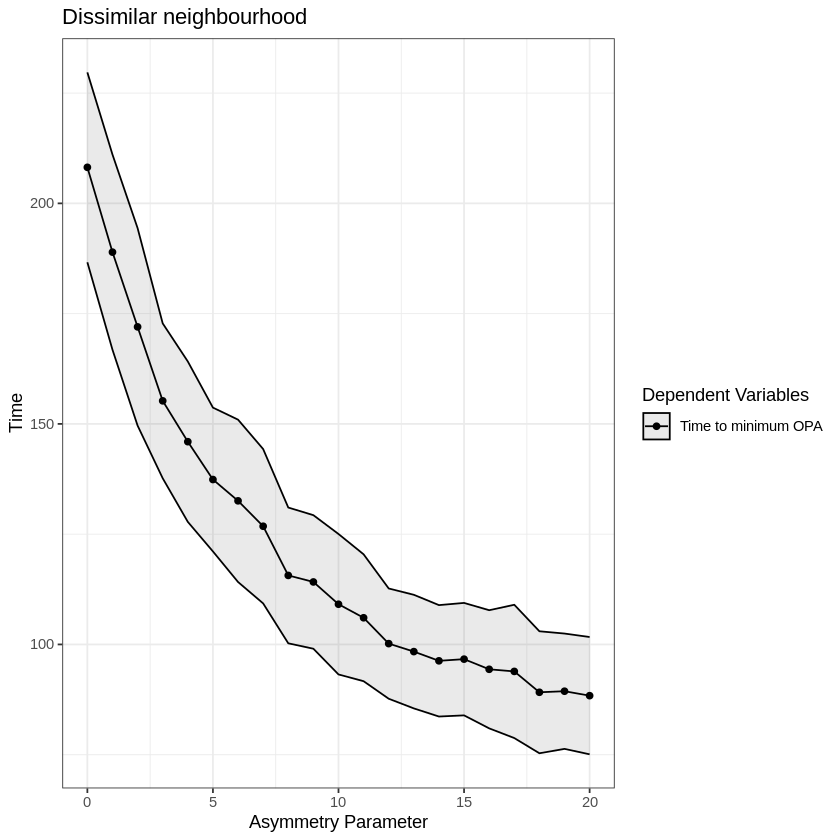

In [5]:
new_data <- tibble(0:20,d_m_t$V1)
new_data<-new_data %>%
  rename("Asymmetry" = 1)
new_data<-new_data %>%
  rename("Time" = 2)
colors <- c("Time to minimum OPA" = "black")
lower <- d_m_t$V1-d_s_t$V1
upper <- d_m_t$V1+d_s_t$V1

fig <-ggplot(data=new_data,aes(x=Asymmetry,y=Time,colour="Time to minimum OPA",group="Time to minimum OPA"))+
        geom_ribbon(aes(x=Asymmetry,ymin=lower,
                      ymax=upper),alpha=0.1) +  
  geom_point()+  
    geom_line()+
      labs(x="Asymmetry Parameter",y="Time",title="Dissimilar neighbourhood") + 
      scale_color_manual(name = "Dependent Variables",
                        values = colors)+
      theme_bw()

print(fig)

In [6]:
d_m_t

X,V1
<int>,<dbl>
1,208.17
2,188.94
3,172.00
4,155.23
5,145.97
6,137.39
7,132.56
8,126.80
9,115.65


In [7]:
new_data <- tibble(0:20,d_m_t$V1,d_s_t$V1)

In [8]:
new_data <- new_data %>% rename("Asymmetry" = 1)
new_data <- new_data %>% rename("Mean Time" = 2)
new_data <- new_data %>% rename("SD" = 3)

In [9]:
row <- 0:20
new_data%>%filter(Asymmetry==row)

Asymmetry,Mean Time,SD
<int>,<dbl>,<dbl>
0,208.17,21.52755
1,188.94,22.12536
2,172.00,22.38506
3,155.23,17.55618
4,145.97,18.18061
5,137.39,16.30263
6,132.56,18.40253
7,126.80,17.49747
8,115.65,15.39013


In [10]:
new_data$Asymmetry

[1]  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20

In [11]:
row

[1]  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20